# Plot Path

Given an ordered set of cells, produces downstream visualizations. To be used in conjunction with Paga.ipynb and operates on outputs of that notebook. Refer to PAGA graph for paths.

In [2]:
library(SnapATAC)
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ClusterR)
library(RColorBrewer)

Loading required package: Matrix

Loading required package: rhdf5

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


Loading required package: gtools



In [3]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [4]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [ ]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [ ]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster, pseudotime coordinates
metaData = read.table("./sessions/20200223_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData = metaData[order(rownames(metaData)), ]
head(metaData, 2)

In [ ]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [ ]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

In [ ]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

In [ ]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [ ]:
x.sp

In [ ]:
# Note that the peaks matrix is not binarized

In [ ]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap.1", "umap.2")])

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

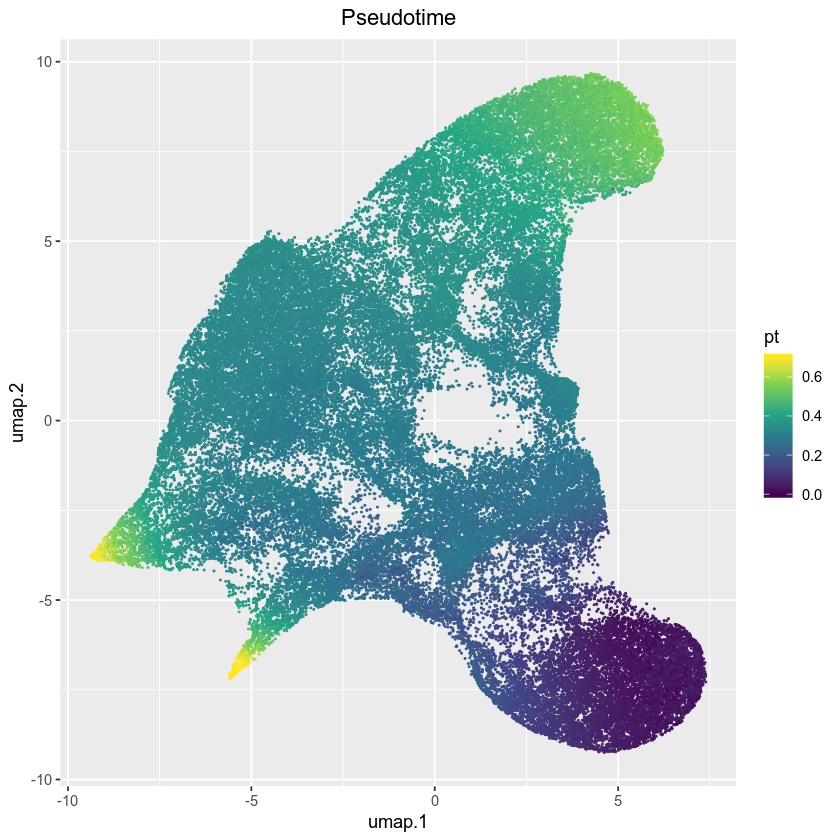

In [361]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, pt=metaData$dpt_pseudotime)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=pt)) +
geom_point(size=0.2, alpha=1) +
scale_color_viridis_c(limits=c(0,0.7), oob=squish) +
ggtitle("Pseudotime") + 
theme(plot.title = element_text(hjust = 0.5))

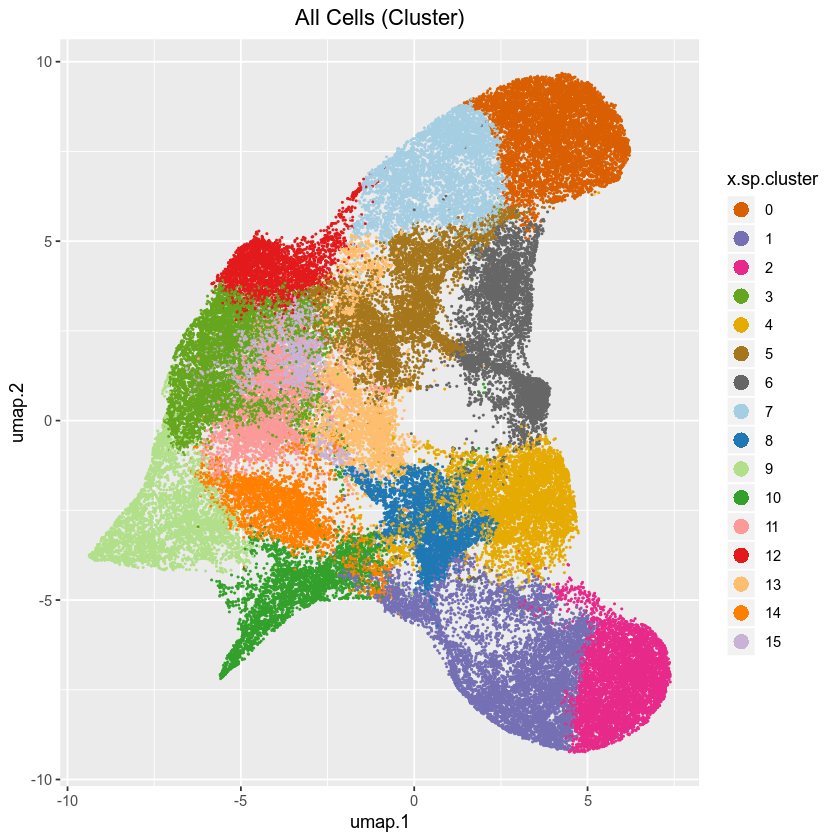

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.2, alpha=1) +
scale_colour_manual(values = col_vector[seq(10,67)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [1019]:
table(x.sp@sample[x.sp@cluster=="13"])


 D10  D12  D14   D2   D4   D6   D8 
1642   41   98   17  484  254  524 

In [ ]:
# Load ChromVAR
chromvar = read.table(gzfile("../20200206_pmat_snapATAC/sessions/20200220_n74838/chromvar.tsv.gz"), 
                      sep='\t')
chromvar = chromvar[order(rownames(chromvar)),]
head(chromvar)

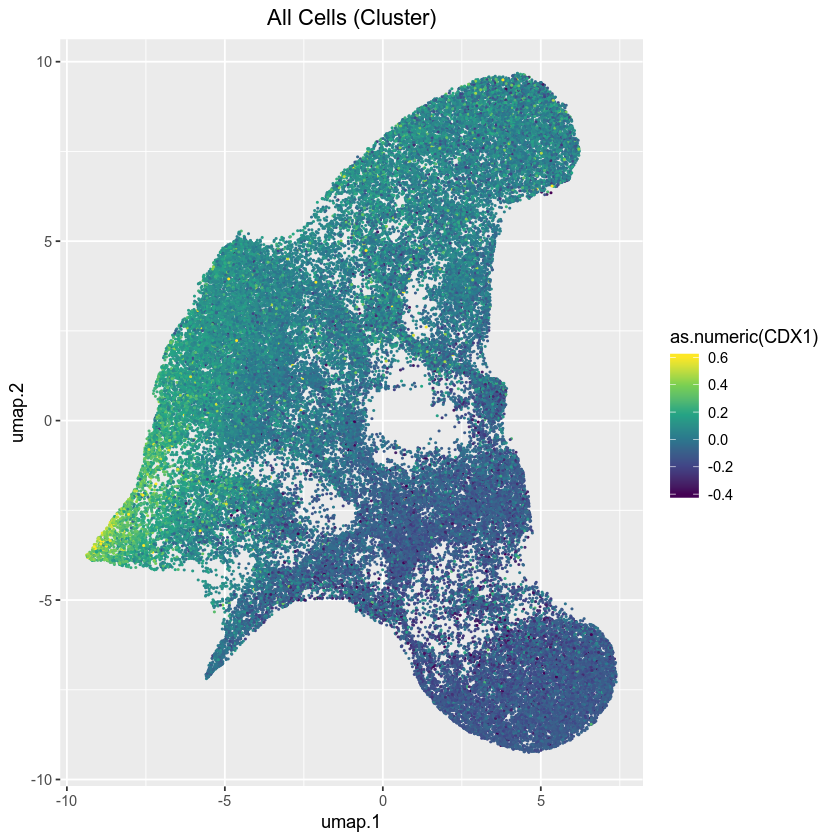

In [38]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@cluster, chromvar[,5:ncol(chromvar)])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=as.numeric(CDX1))) +
geom_point(size=0.2, alpha=1) +
scale_color_viridis_c(limits=c(-0.4,0.6), oob=squish) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) 

## Plot a Path

In [943]:
# clusters_in_path = c(2, 1, 14, 13, 15,11, 3, 12, 7, 0)
# clusters_in_path = c(14, 13, 15,11, 3)
# clusters_in_path = c(2, 1, 10)
clusters_in_path = c(2, 1, 14, 9)

In [946]:
cells_in_path = metaData[metaData$cluster %in% clusters_in_path, ]
cells_in_path = cells_in_path[order(cells_in_path$dpt_pseudotime), ]
dim(cells_in_path)

[1] 20514     6

In [947]:
SUBSAMPLE_TO = 20000

cells_in_path = cells_in_path[sort(sample(nrow(cells_in_path), SUBSAMPLE_TO)), ]
dim(cells_in_path)

[1] 20000     6

In [574]:
df = data.frame(x.sp@umap, x.sp@sample, in_path_alpha=ifelse(x.sp@cluster %in% clusters_in_path, 1, 0))

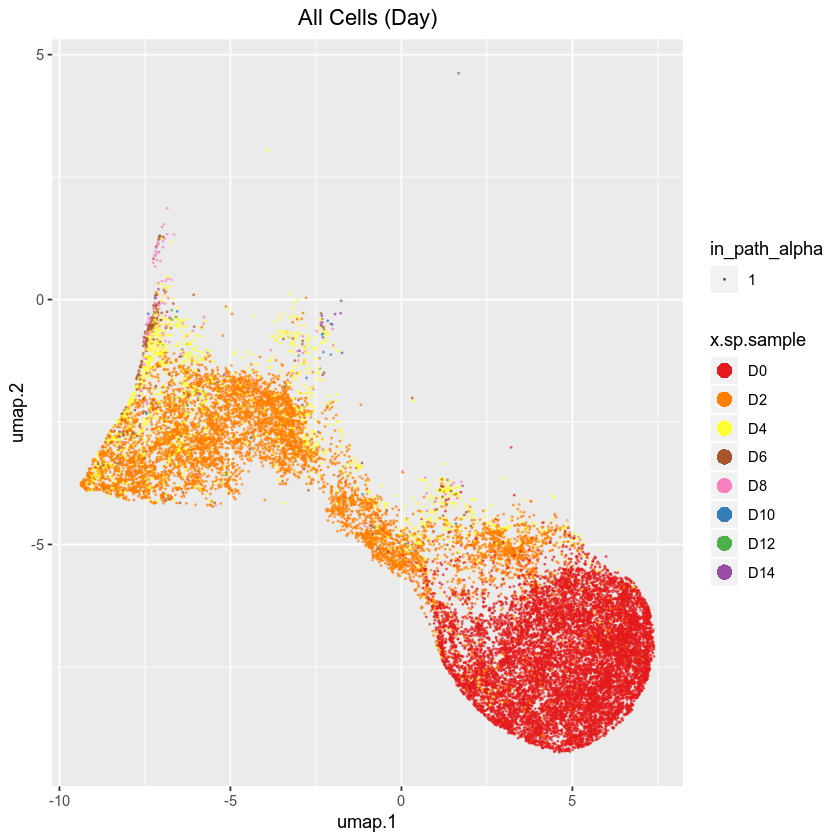

In [575]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample, cluster=x.sp@cluster,
                in_path_alpha=ifelse(x.sp@cluster %in% clusters_in_path, 1, 0))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df[df$cluster %in% clusters_in_path,]) +
geom_point(size=0.2, aes(x=umap.1 , y=umap.2, col=x.sp.sample, alpha=in_path_alpha)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

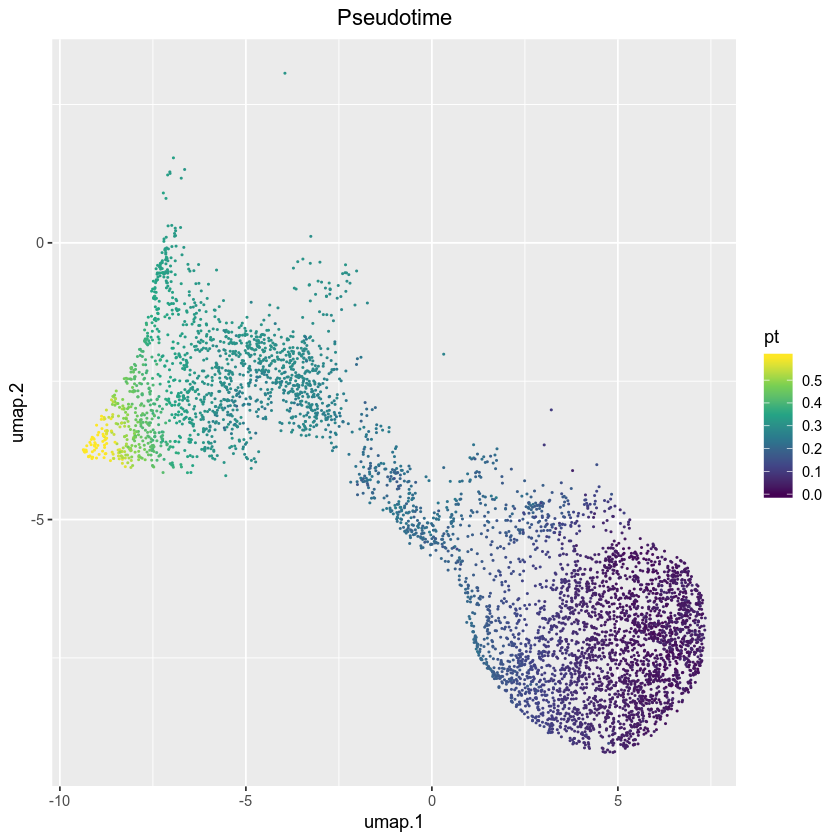

In [576]:
options(repr.plot.width = 7, repr.plot.height = 7)
df = data.frame(cells_in_path[,c("umap.1", "umap.2")], pt=cells_in_path$dpt_pseudotime)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=pt)) +
geom_point(size=0.2, alpha=1) +
scale_color_viridis_c(limits=c(0,0.6), oob=squish) +
ggtitle("Pseudotime") + 
theme(plot.title = element_text(hjust = 0.5))

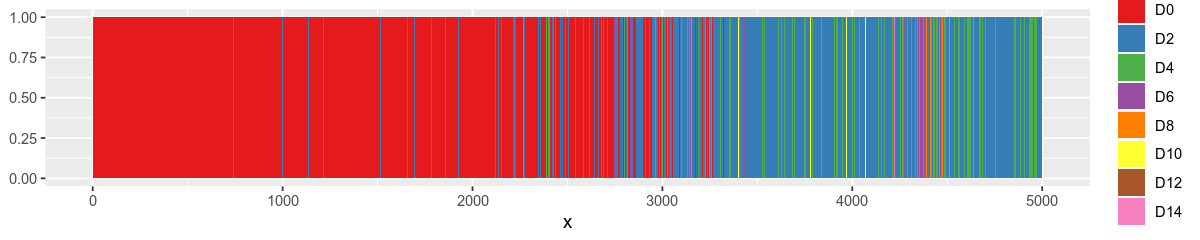

In [577]:
options(repr.plot.width = 10, repr.plot.height = 2)

cur_df = data.frame(x=seq(1,nrow(cells_in_path)),
                    d=factor(cells_in_path$sample,
                            levels=DAYS))
ggplot(cur_df) +
geom_col(aes(x=x, y=1, fill=d),  width=1) +
scale_fill_brewer(breaks=DAYS, palette = "Set1") +
ylab(NULL)

## Plot ChromVAR

In [578]:
motif_df = t(chromvar[rownames(cells_in_path),5:ncol(chromvar)])

# remove NAs
motif_df = motif_df[, colSums(is.na(motif_df))==0]

head(motif_df)
dim(motif_df)

,D0_AAACAACGACGATTAC,D0_AATTCTGCTTGCGTGC,D0_GCCGAACTGCACCTAA,D0_GGTTCAATGTCTGTAG,D0_CGTTATGGAAACCCGC,D0_CCAGCACGACATTCAG,D0_TGAACTGTGATCGGTT,D0_CCCACCTCTCCTACGG,D0_ACCTCCAACCGGTACC,D0_CATAGTCGATCGGGCT,⋯,D2_TTGTTAGCTCAAGTTC,D2_GGTGGAAACTGCTCAA,D2_GAAGTATGATGCGTGC,D4_CTGTAACGAAGAGGCT,D2_GGATTTGACTACAGAA,D2_TTGTGGTGAATCCTTT,D2_GCCCTTAACTCTTTGT,D2_ACGGGTAGACTTCACC,D2_TCGGACCGAGCCGTTG,D2_ATGCATCGATGGCTGC
NFIL3,-0.06097807,-0.073063549,0.01652997,-0.04428635,-0.107714469,0.02149702,0.12892236,-0.11645929,-0.06455442,-0.08731753,⋯,0.19713262,0.51250303,0.35675140,0.31219794,0.35341114,0.45987423,0.61468899,0.63916279,0.29469163,0.24112497
FOXF2,0.12900294,0.111380356,0.16808291,0.21501055,0.124496022,0.16970928,0.33733097,0.15733997,0.13232947,0.10620401,⋯,0.07034256,-0.03116560,-0.01284204,0.05369906,0.05729332,0.01407228,0.24822703,0.04589167,-0.26545726,0.15030572
FOXD1,0.12268214,0.104017049,0.15469480,0.02319600,0.192308008,0.07944231,0.36892598,0.12887931,0.12742055,0.12224961,⋯,0.04784329,-0.06435382,-0.06384592,0.01564668,-0.09061252,-0.02417739,0.32437440,0.09691001,-0.13242282,-0.01978073
IRF2,0.02370880,0.034574225,0.01205642,0.01933340,0.039361066,-0.07548048,0.26927373,0.03780313,0.01060644,-0.08005019,⋯,0.18404865,0.21636520,0.22024558,0.09544018,0.29788630,0.21973962,-0.03501082,0.05847483,0.17007365,0.19222807
MZF1,-0.03350387,-0.014918268,-0.04849881,-0.03324022,-0.035967700,-0.02892200,0.01690723,-0.04155437,-0.05086800,-0.06357606,⋯,0.12802231,0.06693436,0.14454078,0.17689488,0.12059521,0.15042787,0.11546203,0.11083581,0.08598246,0.11268849
MZF1.var.2.,-0.07210584,-0.008249222,-0.07990947,0.01085133,0.005260539,-0.02386297,0.08539974,-0.11766205,-0.01904886,-0.04716579,⋯,0.16545006,0.04442549,0.18370962,0.06978657,0.13100114,0.09545868,-0.01269745,-0.04398489,0.09872258,0.10012886


[1]  453 4978

In [579]:
# remove redundant motifs
motif_cors = cor(t(motif_df), method='spearman')
motif_cors[upper.tri(motif_cors)] = 0
diag(motif_cors) = 0
motif_df = motif_df[!apply(motif_cors,1,function(x) any(x > 0.85)), ]
dim(motif_df)                           

[1]  370 4978

In [580]:
# z-norm per cell (there seemed to be a trended bias such that most motifs at later days had higher motif scores)
motif_df = scale(motif_df)

# clip quantiles
clip <- function(x){
    quantiles <- quantile( x, c(.05, .95 ) )
    x[ x < quantiles[1] ] <- quantiles[1]
    x[ x > quantiles[2] ] <- quantiles[2]
    x
}

motif_df = t(apply(motif_df, 1, clip))

# scale to 0-1
motif_df = motif_df - apply(motif_df, 1, min)
motif_df = motif_df/apply(motif_df, 1,max)

In [581]:
# smooth
motif_df_smooth = t(apply(motif_df, 1, smooth))
colnames(motif_df_smooth) = colnames(motif_df)
motif_df = motif_df_smooth
dim(motif_df)

[1]  370 4978

In [582]:
TOP = 50

# choose top TOP by variance
row_vars = apply(motif_df, 1, var)
motif_df = motif_df[rev(order(row_vars))[1:TOP], ]

In [583]:
# take subset
# tf_list = c("POU5F1", "SOX2", "KLF4", "ZBTB7B", "CTCF", "YY1", "TFAP2B", 
#                      "BACH2", "JUNB", "FOXC2", "FOXB1", "ATF4", "JUN", "CEBPA")
# motif_df = motif_df[tf_list, ]

In [584]:
# order rows (motifs)
row_distance = dist(t(scale(t(motif_df))))
row_cluster = hclust(row_distance, method="ward")
row_dendrogram = as.dendrogram(row_cluster)
rowInd = rev(order.dendrogram(row_dendrogram))

motif_df_row_ordered = as.matrix(motif_df[rowInd, ])
head(motif_df_row_ordered, 2)

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



,D0_AAACAACGACGATTAC,D0_AATTCTGCTTGCGTGC,D0_GCCGAACTGCACCTAA,D0_GGTTCAATGTCTGTAG,D0_CGTTATGGAAACCCGC,D0_CCAGCACGACATTCAG,D0_TGAACTGTGATCGGTT,D0_CCCACCTCTCCTACGG,D0_ACCTCCAACCGGTACC,D0_CATAGTCGATCGGGCT,⋯,D2_TTGTTAGCTCAAGTTC,D2_GGTGGAAACTGCTCAA,D2_GAAGTATGATGCGTGC,D4_CTGTAACGAAGAGGCT,D2_GGATTTGACTACAGAA,D2_TTGTGGTGAATCCTTT,D2_GCCCTTAACTCTTTGT,D2_ACGGGTAGACTTCACC,D2_TCGGACCGAGCCGTTG,D2_ATGCATCGATGGCTGC
MAF.NFE2,0.5648851,0.5648851,0.5648851,0.6071039,0.6071039,0.5973379,0.577806,0.5778060,0.5811741,0.5929243,⋯,0.0216282,0.0216282,0.0216282,0.04352092,0.0448488,0.0448488,0.0448488,0.04406533,0.01468844,0.00000000
BATF.JUN,0.6799228,0.6799228,0.6799228,0.6362470,0.6362470,0.6362470,0.636247,0.6221581,0.6221581,0.6221581,⋯,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0995133,0.1239454,0.12394543,0.11212152,0.08847369


In [585]:
melted = melt(motif_df_row_ordered[, seq(1,ncol(motif_df_row_ordered), 10)])
melted$Var1 = factor(melted$Var1, levels=rownames(motif_df_row_ordered))
melted$Var2 = factor(melted$Var2, levels=colnames(motif_df_row_ordered))

In [586]:
head(melted, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,MAF.NFE2,D0_AAACAACGACGATTAC,0.5648851
2,BATF.JUN,D0_AAACAACGACGATTAC,0.6799228


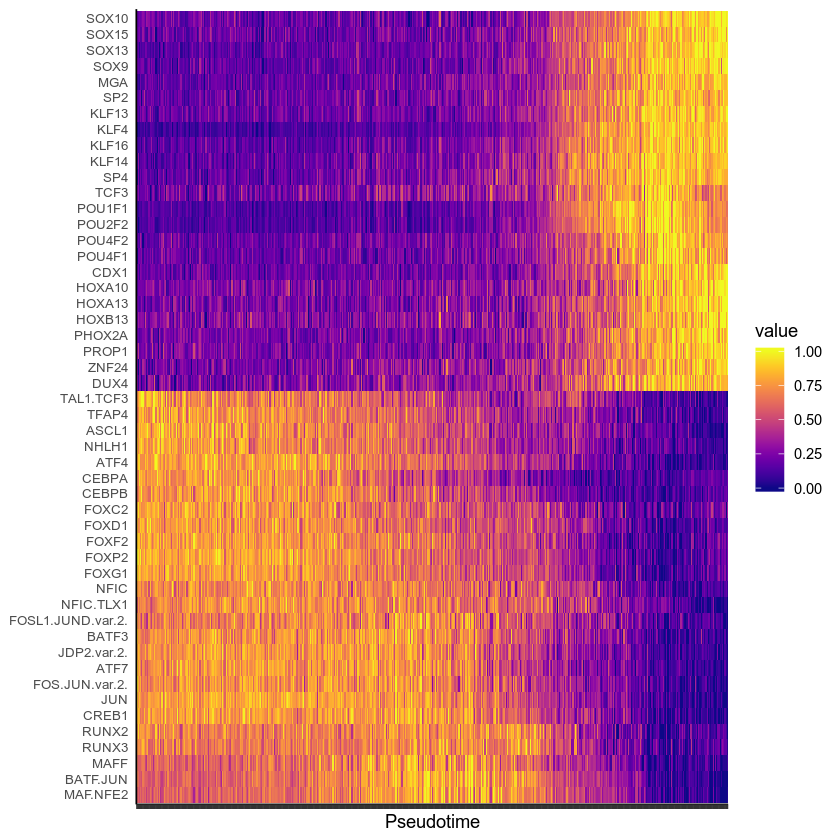

In [587]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(data = melted, mapping = aes(x = Var2,
                                    y = Var1,
                                    fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(-1, 1), oob=squish, option = "B") +
# scale_fill_gradient(limits=c(0, 1), oob=squish, low="dodgerblue4", high="khaki1") +
scale_fill_viridis(limits=c(0,1), oob=squish, option='C') +
# facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
theme_classic() +
theme(axis.text.x=element_blank(),
      axis.text.y=element_text(angle=0,hjust=1, size=8),
#       axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
#       panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3)) 
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_pluripotency_pseudotime_chromvar.jpeg", format(Sys.Date(), format='%Y%m%d')),
#        width = 15, height = 5, dpi=300)

## Plot Raw Peaks

In [948]:
x.sp.path = x.sp[paste(x.sp@sample, x.sp@barcode, sep='_') %in% rownames(cells_in_path), ]

# sort by pseudotime
x.sp.path = x.sp.path[order(cells_in_path[paste(x.sp.path@sample, x.sp.path@barcode, sep='_'), "dpt_pseudotime"]),]

In [949]:
# check orders are the same
all(paste(x.sp.path@sample, x.sp.path@barcode, sep='_')==rownames(cells_in_path))

[1] TRUE

In [590]:
# choose peaks with sufficient counts, but not too high
peak_frac = Matrix::colMeans(x.sp.path@pmat)
q = quantile(peak_frac[peak_frac>0], c(0.3,0.8))

In [591]:
q*100

30%  80% 
0.36 2.34

In [592]:
x.sp.path = x.sp.path[, (peak_frac>q[1])&(peak_frac<q[2]), "pmat"]

In [593]:
x.sp.path

number of barcodes: 5000
number of bins: 0
number of genes: 0
number of peaks: 226159
number of motifs: 0

In [741]:
PEAKS_TO_SAMPLE = 100000
peak_mat = x.sp.path@pmat[, sample(ncol(x.sp.path@pmat), PEAKS_TO_SAMPLE)]

In [742]:
# extend each peak EXTEND steps in pseudotime
EXTEND = 10
extend_peaks <- function(x) {
    mileage = 0
    for (i in seq(length(x))) {
        if (x[i]>0) {
            mileage = EXTEND
        }
        else {
            if (mileage>0) {
                x[i] = 1
                mileage = mileage - 1
            }
        }
    }
    
    x
}

In [743]:
# shuffling for NULL (don't do as part of normal routine)
# peak_mat = peak_mat[sample(nrow(peak_mat)), ]

In [744]:
# choose peaks that aren't spread too much
# pt_vars = apply(peak_mat, 2, function (x) {var(which(x>0))})
# peak_mat = as.matrix(peak_mat[, pt_vars < quantile(pt_vars, 0.1)])

In [745]:
# sort by median
# peak_mat_row_ordered = as.matrix(t(peak_mat[,order(apply(peak_mat, 2, function (x) {median(which(x>0))}))]))
# colnames(peak_mat_row_ordered) = rownames(cells_in_path)

In [746]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [747]:
# first densify in pseudotime 
peak_mat = t(as.matrix(peak_mat))

# ENSURE second arg of create_sum_matrix is a divisor of the first
peak_mat_to_cluster = as.matrix(peak_mat) %*% create_sum_matrix(ncol(peak_mat), 50)

# binarize it
# peak_mat_to_cluster = as.matrix((peak_mat_to_cluster>0)+0)

km_mb = MiniBatchKmeans(peak_mat_to_cluster, 
                        batch_size = 1000,
                        clusters=10,
                        num_init = 10, 
                        verbose = FALSE)

In [857]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(peak_mat_to_cluster, km_mb$centroids)

# use hierarchical clustering on median
# distance    = dist(t(scale(t(km_mb$centroids))))
# cluster     = hclust(distance, method="ward")
# dendrogram  = as.dendrogram(cluster)
# rowInd = rev(order.dendrogram(dendrogram))

# sort by weighted position median -- not sure if this works
rowInd = order(apply(t(scale(t(km_mb$centroids))), 1, function (x) {mean(which(x>0))}))

pr_mb = order(rowInd)[pr_mb]

In [858]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10 
 8925 18604     2  6422 35577  2539  7681  1377 13282  5591 

In [863]:
peak_mat_row_ordered = peak_mat[order(pr_mb),]
# peak_mat_row_ordered = km_mb$centroids[rowInd,]
# colnames(peak_mat_row_ordered) = rownames(cells_in_path)
colnames(peak_mat_row_ordered) = seq(1, ncol(peak_mat_row_ordered))
head(peak_mat_row_ordered, 2)

1,2,3,4,5,6,7,8,9,10,⋯,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [867]:
# subsample for speed 
peak_mat_to_plot = peak_mat_row_ordered[seq(1,nrow(peak_mat_row_ordered), 500), seq(1,ncol(peak_mat_row_ordered), 1)]

# extend for better viewing
peak_mat_to_plot = t(apply(peak_mat_to_plot, 1, extend_peaks))

melted = melt(peak_mat_to_plot)
# melted$Var1 = factor(melted$Var1, levels=rownames(peak_mat_to_plot))
melted$Var2 = factor(melted$Var2, levels=colnames(peak_mat_to_plot))

In [868]:
head(melted, 2)

,Var1,Var2,value
,<int>,<fct>,<dbl>
1,1,1,0
2,2,1,0


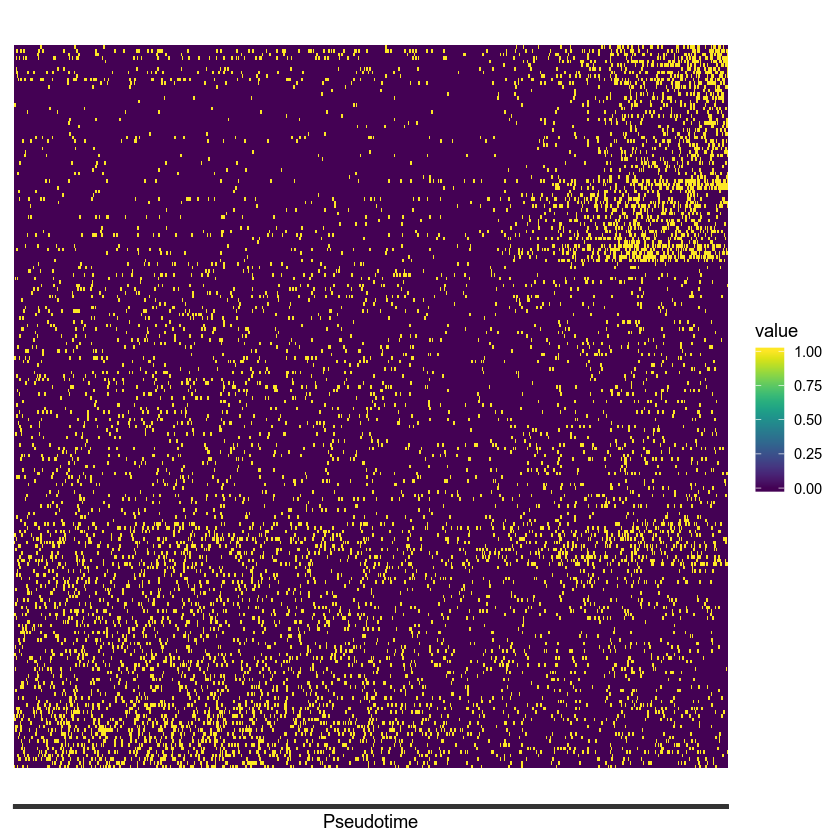

In [869]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(data = melted, mapping = aes(x = Var2,
                                    y = Var1,
                                    fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(-1, 1), oob=squish, option = "B") +
# scale_fill_gradient(limits=c(0, 1), oob=squish, low="dodgerblue4", high="khaki1") +
scale_fill_viridis(limits=c(0,1), oob=squish, option='D') +
# facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_blank(),
#       axis.text.y=element_text(angle=0,hjust=1, size=8),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())

#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3)) 
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_pluripotency_pseudotime_chromvar.jpeg", format(Sys.Date(), format='%Y%m%d')),
#        width = 15, height = 5, dpi=300)

In [107]:
plot(seq(1,ncol(peak_mat_row_ordered)), peak_mat_row_ordered[1001,]>0)

ERROR: Error in peak_mat_row_ordered[1001, ]: subscript out of bounds


## Pseudotime cluster analysis

In [910]:
library(DESeq2)
library(ggrepel)

In [ ]:
x.sp.path = x.sp[paste(x.sp@sample, x.sp@barcode, sep='_') %in% rownames(cells_in_path), ]

# sort by pseudotime
x.sp.path = x.sp.path[order(cells_in_path[paste(x.sp.path@sample, x.sp.path@barcode, sep='_'), "dpt_pseudotime"]),]

# check orders are the same
all(paste(x.sp.path@sample, x.sp.path@barcode, sep='_')==rownames(cells_in_path))

In [976]:
peak_mat = t(x.sp.path@pmat)
peak_mat_cluster = peak_mat %*% create_sum_matrix(ncol(peak_mat), 2000)
rownames(peak_mat_cluster) = as.character(x.sp.path@peak)

In [978]:
peak_mat_cluster = peak_mat_cluster[rowSums(as.matrix(peak_mat_cluster))>50, ]
dim(peak_mat_cluster)

[1] 366223     10

In [979]:
sf = estimateSizeFactorsForMatrix(as.matrix(peak_mat_cluster))
norm_cts = t(as.matrix(t(peak_mat_cluster))/sf)

In [980]:
head(norm_cts, 2)

chr1:180686-181260,24.25364,22.94106,19.80313,22.19779,28.64798,22.04910,11.014813,11.35855,17.52609,20.16926
chr1:181268-181597,14.08276,25.23517,15.23317,10.24513,10.74299,19.45509,9.441268,21.45503,20.15500,22.41029


In [981]:
log_norm_cts = log2(1+norm_cts)

In [982]:
pca = prcomp(t(log_norm_cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
pcs$clust_num = seq(1,10)
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

 [1] 79.19  6.11  3.59  2.82  1.98  1.72  1.55  1.53  1.51  0.00


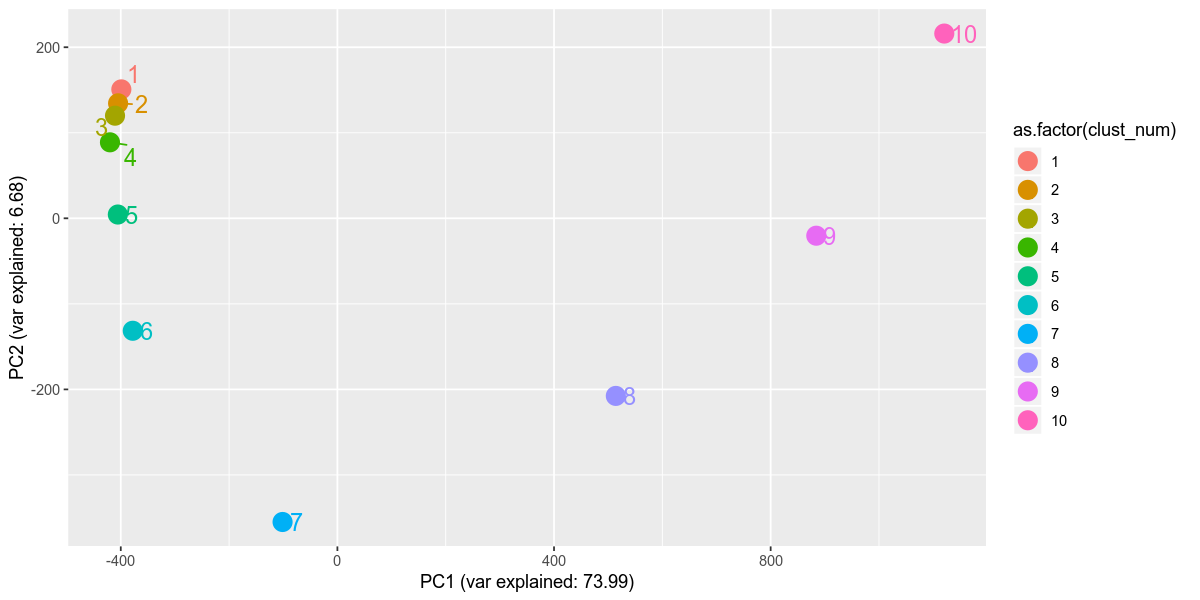

In [955]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=pcs,aes(x=PC1,y=PC2,color=as.factor(clust_num),label=ID))+
geom_point(size=5)+
# scale_colour_manual() +
geom_text_repel(size=5, nudge_x = 10)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

In [988]:
cts_to_cluster = log_norm_cts 
# cts_to_cluster = t(scale(t(log_norm_cts)))

In [989]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters=10,
                        num_init = 10, 
                        verbose = FALSE)

In [990]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



In [991]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10 
42816 38724 42780 15547 25942 28871 42160 53073 49305 27005 

In [992]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

chr1:502571-502779,4.566139,5.015818,5.010243,4.687009,4.845627,5.271021,5.021075,2.869931,1.859537,2.124839
chr1:586102-586306,4.123491,3.451689,3.543894,3.491229,2.453187,2.904008,3.148564,1.817264,2.428014,2.454717


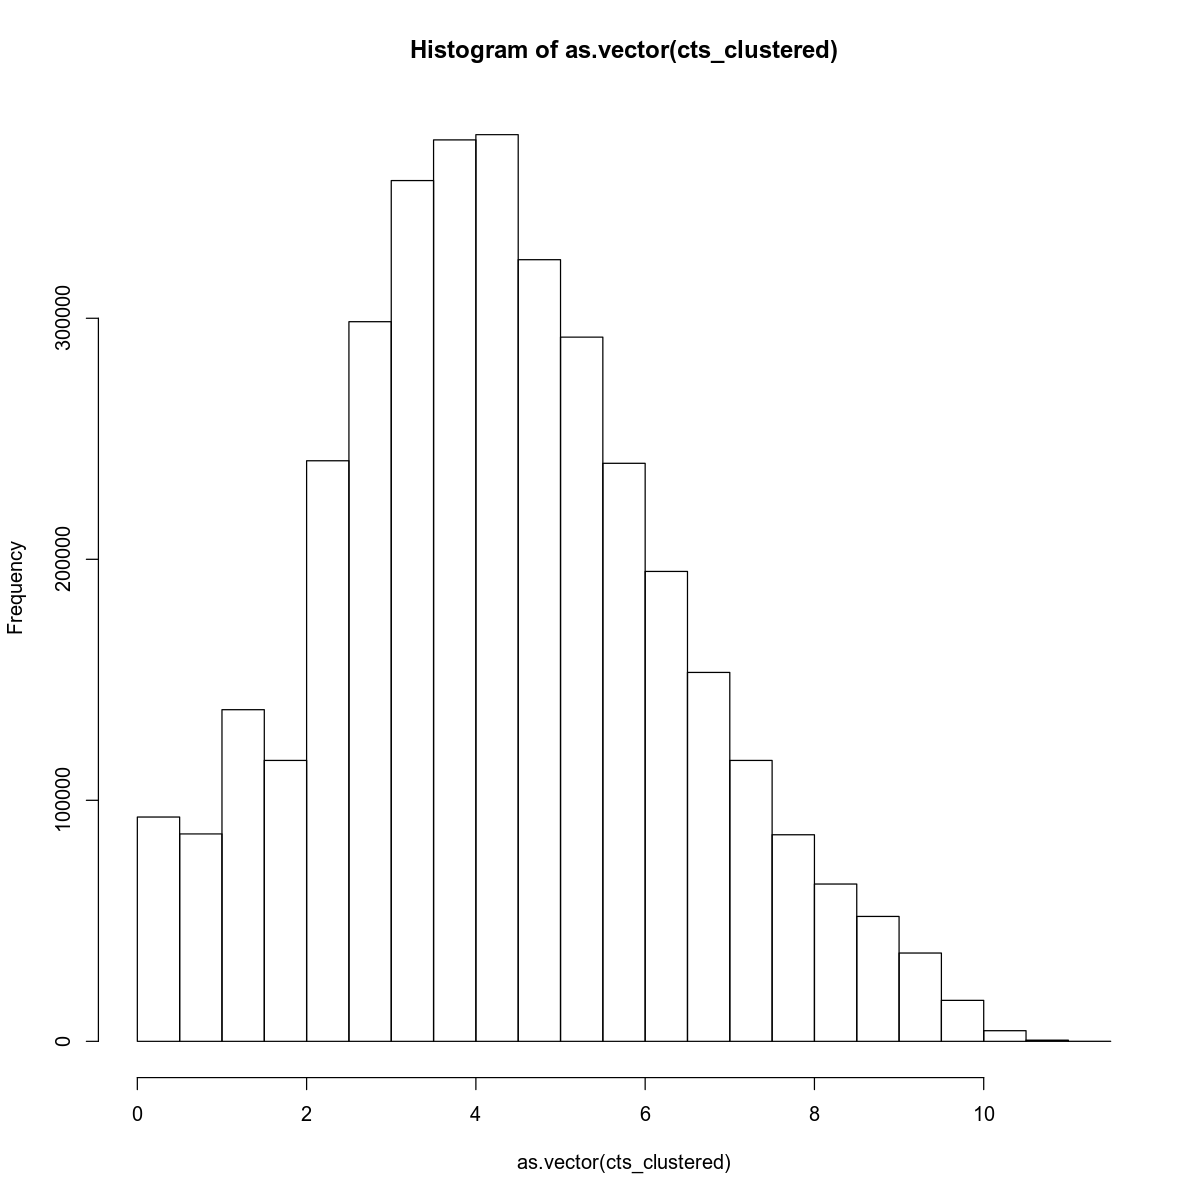

In [993]:
hist(as.vector(cts_clustered))

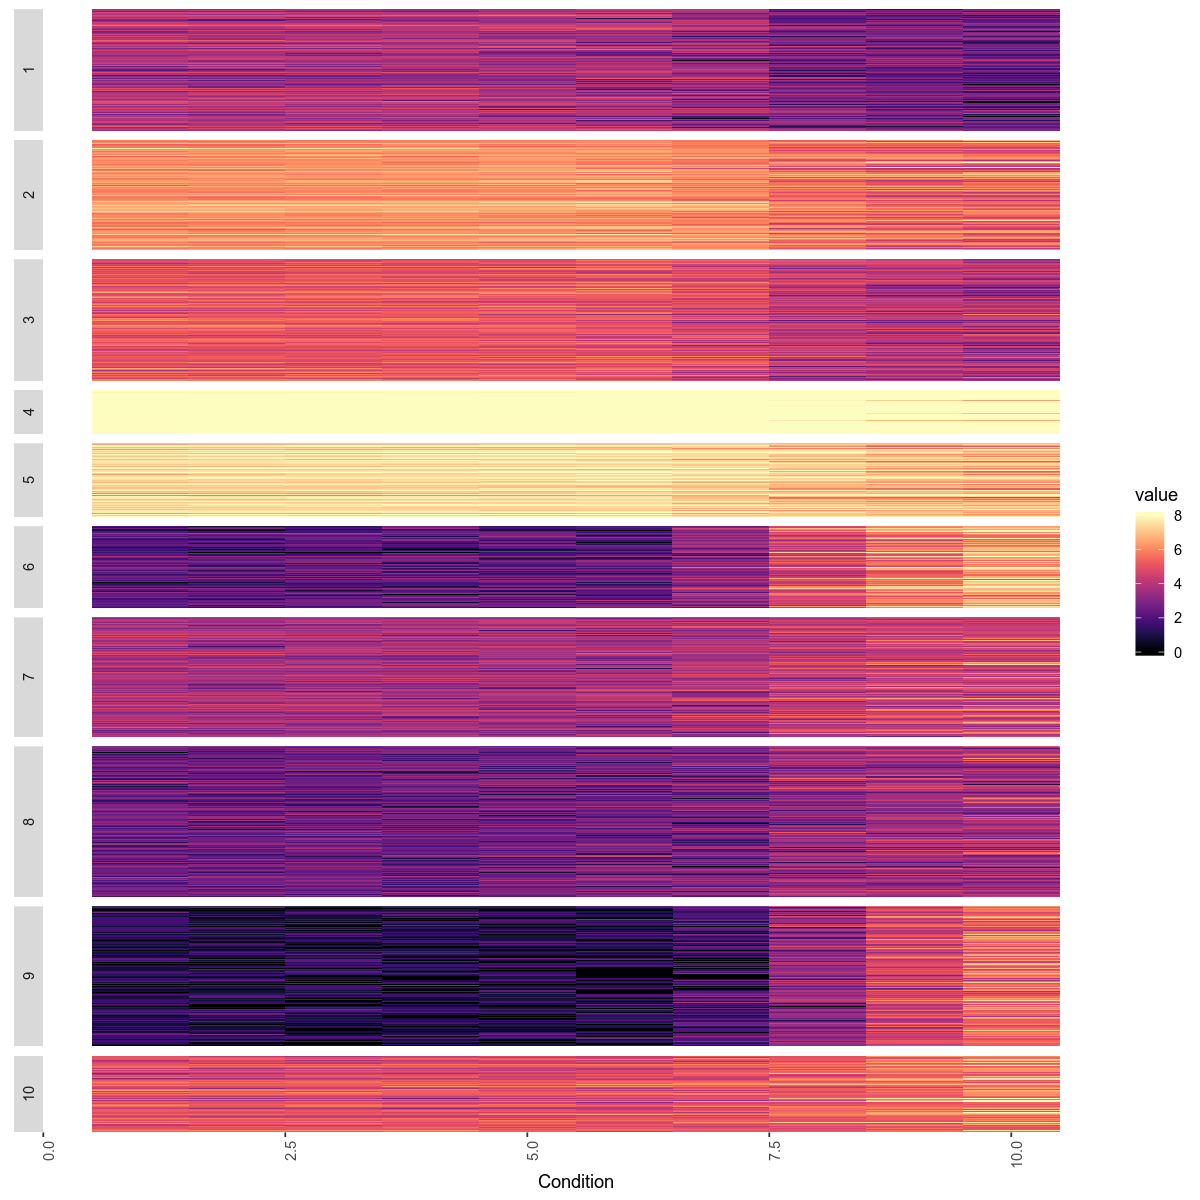

In [995]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 10) # if subsample
ggplot(data = melt(cts_clustered[idxs,]), mapping = aes(x = Var2,
                                                        y = Var1,
                                                        fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(0, 8), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_znorm_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)